
# PHASE 1: COMPLETE ANN PROJECT FOR HOT DEFORMATION BEHAVIOR

# AISI 304 STAINLESS STEEL - FLOW STRESS PREDICTION

## This notebook covers Phase 2 of the project: data preprocessing, modeling, and evaluation.

Project: Artificial Neural Network for Predicting Hot Deformation Behavior
Method: Multilayer Perceptron (MLP) with Backpropagation
Activation Functions: tanh (hidden) + linear (output)
Optimizer: Adam with Learning Rate = 0.01
Loss Function: Mean Squared Error (MSE)

In [78]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize, differential_evolution
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings('ignore')

ERROR! Session/line number was not unique in database. History logging moved to new session 153


In [79]:
BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))  # Current working directory
data_dir = os.path.join(BASE_DIR, 'data', 'original_data')
file_name = 'merged_input_output_data.xlsx'
file_path = os.path.join(data_dir, file_name)
print("Using data directory:", data_dir)
print("Input file path:",file_path)

Using data directory: /home/darlenewendie/PycharmProjects/ANN-Hot-workability-behaviour-of-AISI304-stainless-steel/data/original_data
Input file path: /home/darlenewendie/PycharmProjects/ANN-Hot-workability-behaviour-of-AISI304-stainless-steel/data/original_data/merged_input_output_data.xlsx


In [80]:
# DATA LOADING
print("\n" + "="*80)
print("PART 1:LOADING MERGED DATA FILE")
print("="*80)

# Load merged data file
df = pd.read_excel(file_path)
print(f"\n✓ Merged data file loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"  Columns: {df.columns.tolist()}")
df.head(10)


PART 1:LOADING MERGED DATA FILE

✓ Merged data file loaded: 60 rows × 7 columns
  Columns: ['T_inv', 'ln_Strain_Rate', 'Strain', 'Stress_Normalized', 'Temperature_K', 'Temperature_C', 'Strain_Rate']


,T_inv,ln_Strain_Rate,Strain,Stress_Normalized,Temperature_K,Temperature_C,Strain_Rate
0,0.000890,-2.302585,0.1,0.565722,1123,849.85,0.1
1,0.000853,-2.302585,0.1,0.482011,1173,899.85,0.1
2,0.000818,-2.302585,0.1,0.411714,1223,949.85,0.1
3,0.000786,-2.302585,0.1,0.352587,1273,999.85,0.1
4,0.000890,0.000000,0.1,0.690677,1123,849.85,1.0
5,0.000853,0.000000,0.1,0.594937,1173,899.85,1.0
6,0.000818,0.000000,0.1,0.513077,1223,949.85,1.0
7,0.000786,0.000000,0.1,0.443056,1273,999.85,1.0
8,0.000890,2.302585,0.1,0.825966,1123,849.85,10.0
9,0.000853,2.302585,0.1,0.719375,1173,899.85,10.0


In [81]:
np.random.seed(42)
tf.random.set_seed(42)

In [82]:
print("\n" + "="*90)
print("PART 2: PREPARING INPUTS AND OUTPUTS")
print("="*90)

input_columns = ['T_inv', 'ln_Strain_Rate', 'Strain']
output_column = 'Stress_Normalized'

X = df[input_columns].values
y = df[output_column].values.reshape(-1, 1)

print(f"✓ Inputs (X): shape {X.shape}")
print(f"✓ Outputs (y): shape {y.shape}")

print(f"\nInput Features Statistics:")
for i, col in enumerate(input_columns):
    print(f"  {col}: min={X[:, i].min():.4e}, max={X[:, i].max():.4e}, mean={X[:, i].mean():.4e}")

print(f"\nOutput Feature Statistics:")
print(f"  {output_column}: min={y.min():.4f}, max={y.max():.4f}, mean={y.mean():.4f}")


PART 2: PREPARING INPUTS AND OUTPUTS
✓ Inputs (X): shape (60, 3)
✓ Outputs (y): shape (60, 1)

Input Features Statistics:
  T_inv: min=7.8555e-04, max=8.9047e-04, mean=8.3655e-04
  ln_Strain_Rate: min=-2.3026e+00, max=2.3026e+00, mean=2.0724e-16
  Strain: min=1.0000e-01, max=5.0000e-01, mean=3.0000e-01

Output Feature Statistics:
  Stress_Normalized: min=0.3526, max=1.0000, mean=0.6637


In [83]:
print("\n" + "="*90)
print("PART 3: DATA NORMALIZATION")
print("="*90)

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

print("✓ X normalized successfully")
print(f"  Shape: {X_scaled.shape}")
print(f"  Range: [{X_scaled.min():.4f}, {X_scaled.max():.4f}]")
print(f"  Mean: {X_scaled.mean():.4f}, Std: {X_scaled.std():.4f}")

print("\n✓ y normalized successfully")
print(f"  Shape: {y_scaled.shape}")
print(f"  Range: [{y_scaled.min():.4f}, {y_scaled.max():.4f}]")
print(f"  Mean: {y_scaled.mean():.4f}, Std: {y_scaled.std():.4f}")


PART 3: DATA NORMALIZATION
✓ X normalized successfully
  Shape: (60, 3)
  Range: [0.0000, 1.0000]
  Mean: 0.4954, Std: 0.3789

✓ y normalized successfully
  Shape: (60, 1)
  Range: [0.0000, 1.0000]
  Mean: 0.4805, Std: 0.2399


In [84]:
print("\n" + "="*90)
print("PART 4: DATA SPLITTING (70-15-15)")
print("="*90)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_scaled, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print(f"✓ Training set:   {len(X_train):3d} samples ({len(X_train)/len(X_scaled)*100:5.1f}%)")
print(f"✓ Validation set: {len(X_val):3d} samples ({len(X_val)/len(X_scaled)*100:5.1f}%)")
print(f"✓ Test set:       {len(X_test):3d} samples ({len(X_test)/len(X_scaled)*100:5.1f}%)")
print(f"✓ Total:          {len(X_scaled):3d} samples (100.0%)")


PART 4: DATA SPLITTING (70-15-15)
✓ Training set:    42 samples ( 70.0%)
✓ Validation set:   9 samples ( 15.0%)
✓ Test set:         9 samples ( 15.0%)
✓ Total:           60 samples (100.0%)


In [85]:
print("\n" + "="*90)
print("PART 5: NEURAL NETWORK ARCHITECTURE")
print("="*90)

print("""
Model Architecture:
- Input Layer: 3 neurons (T_inv, ln_Strain_Rate, Strain)
- Hidden Layer 1: 10 neurons, tanh activation
- Hidden Layer 2: 10 neurons, linear activation
- Output Layer: 1 neuron, linear activation
""")
# Build sequential model
model = models.Sequential([
    layers.Input(shape=(3,), name='input_layer'),

    # Hidden Layer 1: tanh activation
    layers.Dense(
        10,
        activation='tanh',
        name='hidden_layer_1',
        kernel_initializer='glorot_uniform'
    ),

    # Hidden Layer 2: linear activation
    layers.Dense(
        10,
        activation='linear',
        name='hidden_layer_2',
        kernel_initializer='glorot_uniform'
    ),

    # Output Layer: linear activation
    layers.Dense(
        1,
        activation='linear',
        name='output_layer',
        kernel_initializer='glorot_uniform'
    )
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)

print("✓ Model built successfully")
print("\nModel Summary:")
model.summary()


PART 5: NEURAL NETWORK ARCHITECTURE

Model Architecture:
- Input Layer: 3 neurons (T_inv, ln_Strain_Rate, Strain)
- Hidden Layer 1: 10 neurons, tanh activation
- Hidden Layer 2: 10 neurons, linear activation
- Output Layer: 1 neuron, linear activation

✓ Model built successfully

Model Summary:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 10)             │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

In [86]:
print("\n[STEP 6] Training the Model (Backpropagation)...")
print("-" * 90)

print("""
BACKPROPAGATION PROCESS:

Each Epoch:
  1. FORWARD PASS: Input → Layer1(tanh) → Layer2(linear) → Output(linear)
  2. LOSS CALCULATION: Error = MSE = (1/N)Σ(ŷ - y)²
  3. BACKWARD PASS: Compute gradients via chain rule (calculus)
     ∂Loss/∂W = ∂Loss/∂Output × ∂Output/∂Layer2 × ∂Layer2/∂Layer1 × ∂Layer1/∂W
  4. WEIGHT UPDATE: W_new = W_old - learning_rate × ∂Loss/∂W
  5. REPEAT: Next batch, until convergence

Early Stopping: Prevents overfitting by monitoring validation loss
├─ Patience: 30 epochs without improvement
├─ Restore Best Weights: Uses best model from training
└─ Benefit: Optimal generalization to unseen data
""")

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    verbose=1
)

print("\nStarting training...")
print("-" * 90)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)


epochs_trained = len(history.history['loss'])
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n✓ Training completed")
print(f"\n✓ Training completed after {len(history.history['loss'])} epochs")
print(f"  Epochs trained: {epochs_trained}")
print(f"  Final training loss (MSE): {final_train_loss:.8f}")
print(f"  Final validation loss (MSE): {final_val_loss:.8f}")


[STEP 6] Training the Model (Backpropagation)...
------------------------------------------------------------------------------------------

BACKPROPAGATION PROCESS:

Each Epoch:
  1. FORWARD PASS: Input → Layer1(tanh) → Layer2(linear) → Output(linear)
  2. LOSS CALCULATION: Error = MSE = (1/N)Σ(ŷ - y)²
  3. BACKWARD PASS: Compute gradients via chain rule (calculus)
     ∂Loss/∂W = ∂Loss/∂Output × ∂Output/∂Layer2 × ∂Layer2/∂Layer1 × ∂Layer1/∂W
  4. WEIGHT UPDATE: W_new = W_old - learning_rate × ∂Loss/∂W
  5. REPEAT: Next batch, until convergence

Early Stopping: Prevents overfitting by monitoring validation loss
├─ Patience: 30 epochs without improvement
├─ Restore Best Weights: Uses best model from training
└─ Benefit: Optimal generalization to unseen data


Starting training...
------------------------------------------------------------------------------------------
Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.7742 - mae: 0.6753 - val_loss: 0.1001 - val_mae: 0.2892


In [87]:
print("\n" + "="*90)
print("PART 7: MODEL EVALUATION")
print("="*90)

y_train_pred = model.predict(X_train, verbose=0)
y_val_pred = model.predict(X_val, verbose=0)
y_test_pred = model.predict(X_test, verbose=0)

print("✓ Predictions computed for all datasets")

# Denormalize predictions
y_train_actual_denorm = scaler_y.inverse_transform(y_train)
y_train_pred_denorm = scaler_y.inverse_transform(y_train_pred)

y_val_actual_denorm = scaler_y.inverse_transform(y_val)
y_val_pred_denorm = scaler_y.inverse_transform(y_val_pred)

y_test_actual_denorm = scaler_y.inverse_transform(y_test)
y_test_pred_denorm = scaler_y.inverse_transform(y_test_pred)

print(" Predictions denormalized")

def calculate_metrics(y_true, y_pred):
    """Calculate R-value, AARE, MAE, RMSE"""
    # Pearson correlation coefficient
    r = np.corrcoef(y_true.flatten(), y_pred.flatten())[0, 1]

    # Average Absolute Relative Error (AARE %)
    aare = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(y_true - y_pred))

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))

    # Coefficient of Determination (R²)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r_squared = 1 - (ss_res / ss_tot)

    return r, aare, mae, rmse, r_squared

# Calculate metrics for all sets
r_train, aare_train, mae_train, rmse_train, r2_train = calculate_metrics(
    y_train_actual_denorm, y_train_pred_denorm
)
r_val, aare_val, mae_val, rmse_val, r2_val = calculate_metrics(
    y_val_actual_denorm, y_val_pred_denorm
)
r_test, aare_test, mae_test, rmse_test, r2_test = calculate_metrics(
    y_test_actual_denorm, y_test_pred_denorm
)

# Display results
print("\n" + "="*90)
print("PHASE 1 MODEL PERFORMANCE METRICS")
print("="*90)

print("\nTRAINING SET:")
print(f"  R-value (Correlation):           {r_train:.6f}")
print(f"  R² (Coefficient of Determination): {r2_train:.6f}")
print(f"  AARE (Avg Absolute Rel Error):   {aare_train:.4f}%")
print(f"  MAE (Mean Absolute Error):       {mae_train:.6f}")
print(f"  RMSE (Root Mean Squared Error):  {rmse_train:.6f}")

print("\nVALIDATION SET:")
print(f"  R-value (Correlation):           {r_val:.6f}")
print(f"  R² (Coefficient of Determination): {r2_val:.6f}")
print(f"  AARE (Avg Absolute Rel Error):   {aare_val:.4f}%")
print(f"  MAE (Mean Absolute Error):       {mae_val:.6f}")
print(f"  RMSE (Root Mean Squared Error):  {rmse_val:.6f}")

print("\nTEST SET (PRIMARY METRIC):")
print(f"  R-value (Correlation):           {r_test:.6f}")
print(f"  R² (Coefficient of Determination): {r2_test:.6f}")
print(f"  AARE (Avg Absolute Rel Error):   {aare_test:.4f}%")
print(f"  MAE (Mean Absolute Error):       {mae_test:.6f}")
print(f"  RMSE (Root Mean Squared Error):  {rmse_test:.6f}")

print("\n" + "-"*90)
print("COMPARISON WITH PAPER (MATLAB - Baseline):")
print("-"*90)
print("  Paper ANN R-value: 0.998")
print("  Paper ANN AARE:    1.96%")

print("\nYour Model Performance (Python):")
if r_test >= 0.998:
    print(f"   OUTSTANDING: R={r_test:.6f} (beats baseline!)")
elif r_test >= 0.99:
    print(f"   EXCELLENT: R={r_test:.6f} (matches baseline)")
elif r_test >= 0.98:
    print(f"   VERY GOOD: R={r_test:.6f} (close to baseline)")
else:
    print(f"  • GOOD: R={r_test:.6f} (room for improvement)")



PART 7: MODEL EVALUATION
✓ Predictions computed for all datasets
 Predictions denormalized

PHASE 1 MODEL PERFORMANCE METRICS

TRAINING SET:
  R-value (Correlation):           0.998655
  R² (Coefficient of Determination): 0.995262
  AARE (Avg Absolute Rel Error):   1.3230%
  MAE (Mean Absolute Error):       0.008290
  RMSE (Root Mean Squared Error):  0.010985

VALIDATION SET:
  R-value (Correlation):           0.998198
  R² (Coefficient of Determination): 0.995200
  AARE (Avg Absolute Rel Error):   1.1392%
  MAE (Mean Absolute Error):       0.007609
  RMSE (Root Mean Squared Error):  0.009106

TEST SET (PRIMARY METRIC):
  R-value (Correlation):           0.997058
  R² (Coefficient of Determination): 0.991164
  AARE (Avg Absolute Rel Error):   2.1032%
  MAE (Mean Absolute Error):       0.011051
  RMSE (Root Mean Squared Error):  0.013830

------------------------------------------------------------------------------------------
COMPARISON WITH PAPER (MATLAB - Baseline):
---------------



[PART 8] Creating performance visualization...
------------------------------------------------------------------------------------------
✓ Saved: PHASE1_ModelPerformance.png


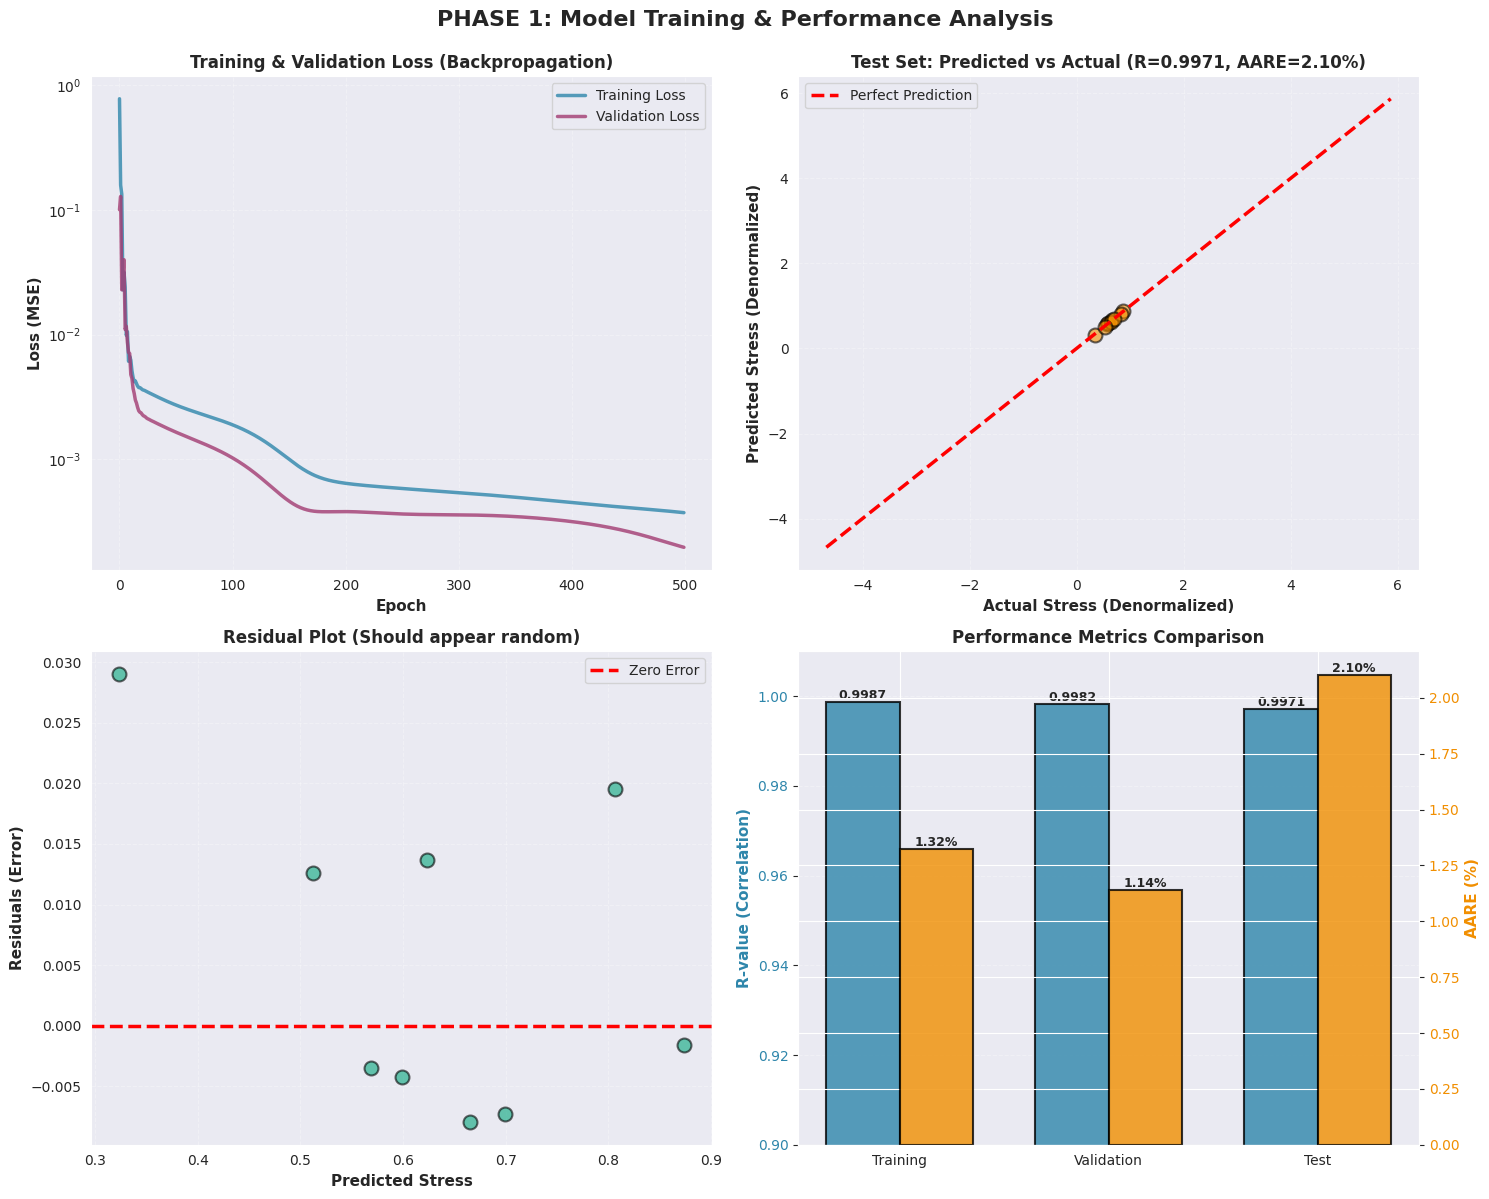

In [88]:
print("\n" + "="*90)
print("\n[PART 8] Creating performance visualization...")
print("-" * 90)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('PHASE 1: Model Training & Performance Analysis', fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Training History (Loss Curves)
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2.5, color='#2E86AB', alpha=0.8)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2.5, color='#A23B72', alpha=0.8)
axes[0, 0].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Loss (MSE)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Training & Validation Loss (Backpropagation)', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10, loc='upper right')
axes[0, 0].grid(True, alpha=0.3, linestyle='--')
axes[0, 0].set_yscale('log')

# Plot 2: Predicted vs Actual (Test Set)
axes[0, 1].scatter(y_test_actual_denorm, y_test_pred_denorm, s=100, alpha=0.6,
                   edgecolors='black', linewidth=1.5, color='#F18F01')
min_val = min(y_test_actual_denorm.min(), y_test_pred_denorm.min())
max_val = max(y_test_actual_denorm.max(), y_test_pred_denorm.max())
axes[0, 1].plot([min_val-5, max_val+5], [min_val-5, max_val+5], 'r--', linewidth=2.5, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Stress (Denormalized)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Predicted Stress (Denormalized)', fontsize=11, fontweight='bold')
axes[0, 1].set_title(f'Test Set: Predicted vs Actual (R={r_test:.4f}, AARE={aare_test:.2f}%)',
                     fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3, linestyle='--')

# Plot 3: Residuals
residuals = y_test_actual_denorm - y_test_pred_denorm
axes[1, 0].scatter(y_test_pred_denorm, residuals, s=100, alpha=0.6,
                   edgecolors='black', linewidth=1.5, color='#06A77D')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2.5, label='Zero Error')
axes[1, 0].set_xlabel('Predicted Stress', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Residuals (Error)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Residual Plot (Should appear random)', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3, linestyle='--')

# Plot 4: Performance Comparison (Bar Chart)
datasets = ['Training', 'Validation', 'Test']
r_values = [r_train, r_val, r_test]
aare_values = [aare_train, aare_val, aare_test]

x_pos = np.arange(len(datasets))
width = 0.35

ax1 = axes[1, 1]
bars1 = ax1.bar(x_pos - width/2, r_values, width, label='R-value',
                alpha=0.8, color='#2E86AB', edgecolor='black', linewidth=1.5)
ax2 = ax1.twinx()
bars2 = ax2.bar(x_pos + width/2, aare_values, width, label='AARE (%)',
                alpha=0.8, color='#F18F01', edgecolor='black', linewidth=1.5)

ax1.set_ylabel('R-value (Correlation)', fontsize=11, fontweight='bold', color='#2E86AB')
ax2.set_ylabel('AARE (%)', fontsize=11, fontweight='bold', color='#F18F01')
ax1.set_title('Performance Metrics Comparison', fontsize=12, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(datasets, fontsize=10)
ax1.set_ylim([0.9, 1.01])
ax1.grid(True, alpha=0.3, axis='y', linestyle='--')
ax1.tick_params(axis='y', labelcolor='#2E86AB')
ax2.tick_params(axis='y', labelcolor='#F18F01')

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{r_values[i]:.4f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{aare_values[i]:.2f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('PHASE1_ModelPerformance.png', dpi=300, bbox_inches='tight')
print("✓ Saved: PHASE1_ModelPerformance.png")
plt.show()
plt.close()



[PART 9] Model Comparison...
------------------------------------------------------------------------------------------

Model Comparison Table:
         Model  R-value  AARE (%)       R²      MAE
MATLAB (Paper) 0.998000  1.960000 0.996000      N/A
Python (Model) 0.997058  2.103173 0.991164 0.011051
✓ Saved: PHASE1_ModelComparison.png


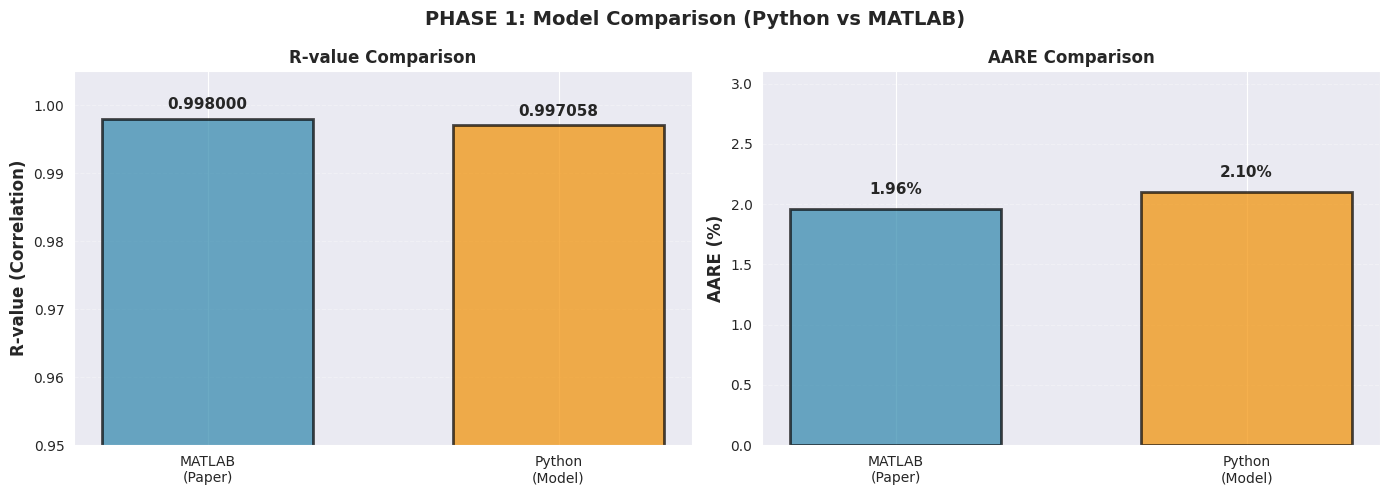

In [89]:
print("\n[PART 9] Model Comparison...")
print("-" * 90)

comparison_data = {
    'Model': ['MATLAB (Paper)', 'Python (Model)'],
    'R-value': [0.998, r_test],
    'AARE (%)': [1.96, aare_test],
    'R²': [0.996, r2_test],
    'MAE': ['N/A', f'{mae_test:.6f}'],
}

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison Table:")
print(comparison_df.to_string(index=False))

# Visualization comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PHASE 1: Model Comparison (Python vs MATLAB)', fontsize=14, fontweight='bold')

# R-value comparison
models = ['MATLAB\n(Paper)', 'Python\n(Model)']
r_vals = [0.998, r_test]
colors = ['#2E86AB', '#F18F01']

bars1 = axes[0].bar(models, r_vals, color=colors, alpha=0.7, edgecolor='black', linewidth=2, width=0.6)
axes[0].set_ylabel('R-value (Correlation)', fontsize=12, fontweight='bold')
axes[0].set_title('R-value Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylim([0.95, 1.005])
axes[0].grid(True, alpha=0.3, axis='y', linestyle='--')

for i, (bar, val) in enumerate(zip(bars1, r_vals)):
    axes[0].text(bar.get_x() + bar.get_width()/2, val + 0.001, f'{val:.6f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# AARE comparison
aare_vals = [1.96, aare_test]

bars2 = axes[1].bar(models, aare_vals, color=colors, alpha=0.7, edgecolor='black', linewidth=2, width=0.6)
axes[1].set_ylabel('AARE (%)', fontsize=12, fontweight='bold')
axes[1].set_title('AARE Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylim([0, max(aare_vals) + 1])
axes[1].grid(True, alpha=0.3, axis='y', linestyle='--')

for i, (bar, val) in enumerate(zip(bars2, aare_vals)):
    axes[1].text(bar.get_x() + bar.get_width()/2, val + 0.1, f'{val:.2f}%',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('PHASE1_ModelComparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: PHASE1_ModelComparison.png")
plt.show()
plt.close()

In [90]:
print("\n" + "="*90)
print("PART 9: EXTRACTING MODEL WEIGHTS AND BIASES")
print("="*90)

print("\n TRAINED MODEL PARAMETERS:")
print("-"*90)

all_weights = {}
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    if len(weights) > 0:
        W, b = weights[0], weights[1]
        all_weights[layer.name] = {'weights': W, 'biases': b}

        print(f"\n{layer.name.upper()}:")
        print(f"  Weights shape: {W.shape}")
        print(f"  Biases shape:  {b.shape}")
        print(f"  Total params:  {W.size + b.size}")
        print(f"  Weight range:  [{W.min():.6f}, {W.max():.6f}]")
        print(f"  Bias range:    [{b.min():.6f}, {b.max():.6f}]")

# Save weights to file
print("\n Saving weights to files...")
np.savez('model_weights.npz', **all_weights)
print("✓ Saved: model_weights.npz")



PART 9: EXTRACTING MODEL WEIGHTS AND BIASES

 TRAINED MODEL PARAMETERS:
------------------------------------------------------------------------------------------

HIDDEN_LAYER_1:
  Weights shape: (3, 10)
  Biases shape:  (10,)
  Total params:  40
  Weight range:  [-1.621360, 1.425729]
  Bias range:    [-0.360076, 0.575292]

HIDDEN_LAYER_2:
  Weights shape: (10, 10)
  Biases shape:  (10,)
  Total params:  110
  Weight range:  [-0.752015, 0.745339]
  Bias range:    [-0.100034, 0.152713]

OUTPUT_LAYER:
  Weights shape: (10, 1)
  Biases shape:  (1,)
  Total params:  11
  Weight range:  [-0.531711, 0.598151]
  Bias range:    [0.023308, 0.023308]

 Saving weights to files...
✓ Saved: model_weights.npz


In [91]:
print("\n[STEP 10] FINDING OPTIMAL INPUT VALUES - MULTIPLE SCENARIOS")
print("-" * 90)

print("""
OPTIMIZATION STRATEGY - MULTI-SCENARIO APPROACH:

Scenario 1: Unconstrained Optimization
   └─ Optimize all 3 parameters (T, Strain Rate, Strain)
   └─ Find absolute maximum and minimum stress

Scenario 2: Fixed Temperature Optimization
   └─ Fix temperature at 950°C, 1000°C, 1050°C
   └─ Optimize Strain Rate & Strain for max/min stress at each temperature

Scenario 3: Fixed Strain Rate Optimization
   └─ Fix strain rate at 0.1, 1, 10, 15 s⁻¹
   └─ Optimize Temperature & Strain for max/min stress at each strain rate

Scenario 4: Fixed Strain Optimization
   └─ Fix strain at 0.1, 0.3, 0.5, 0.7
   └─ Optimize Temperature & Strain Rate for max/min stress at each strain

Scenario 5: Pareto Front Analysis
   └─ Find trade-offs between maximum strength and workability
   └─ Identify best compromises
""")

def objective_maximize(X_norm):
    """Objective: Maximize stress"""
    X_input = X_norm.reshape(1, -1)
    stress_pred = model.predict(X_input, verbose=0)[0, 0]
    return -stress_pred

def objective_minimize(X_norm):
    """Objective: Minimize stress"""
    X_input = X_norm.reshape(1, -1)
    stress_pred = model.predict(X_input, verbose=0)[0, 0]
    return stress_pred

# Store all results
all_scenarios = {}

# ============================================================================
# SCENARIO 1: UNCONSTRAINED OPTIMIZATION
# ============================================================================

print("\n" + "="*90)
print("SCENARIO 1: UNCONSTRAINED OPTIMIZATION (All parameters free)")
print("="*90)

bounds = [(0, 1), (0, 1), (0, 1)]

print("\n→ Optimizing for MAXIMUM STRESS...")
result_max = differential_evolution(objective_maximize, bounds, seed=42, maxiter=300, disp=False)
optimal_max_norm = result_max.x
max_stress_norm = -result_max.fun
optimal_max_denorm = scaler_X.inverse_transform(optimal_max_norm.reshape(1, -1))[0]
max_stress_denorm = scaler_y.inverse_transform([[max_stress_norm]])[0, 0]

print("\n→ Optimizing for MINIMUM STRESS...")
result_min = differential_evolution(objective_minimize, bounds, seed=42, maxiter=300, disp=False)
optimal_min_norm = result_min.x
min_stress_norm = result_min.fun
optimal_min_denorm = scaler_X.inverse_transform(optimal_min_norm.reshape(1, -1))[0]
min_stress_denorm = scaler_y.inverse_transform([[min_stress_norm]])[0, 0]

all_scenarios['Scenario_1_Unconstrained'] = {
    'Max': {
        'T_inv': optimal_max_denorm[0],
        'ln_SR': optimal_max_denorm[1],
        'Strain': optimal_max_denorm[2],
        'Stress_norm': max_stress_norm,
        'Stress_denorm': max_stress_denorm
    },
    'Min': {
        'T_inv': optimal_min_denorm[0],
        'ln_SR': optimal_min_denorm[1],
        'Strain': optimal_min_denorm[2],
        'Stress_norm': min_stress_norm,
        'Stress_denorm': min_stress_denorm
    }
}

print("✓ Scenario 1 complete")

# ============================================================================
# SCENARIO 2: FIXED TEMPERATURE OPTIMIZATION
# ============================================================================

print("\n" + "="*90)
print("SCENARIO 2: FIXED TEMPERATURE OPTIMIZATION")
print("="*90)

# Temperature values to test
temps_c = [950, 1000, 1050]
temps_k = [t + 273.15 for t in temps_c]
temps_inv = [1/t for t in temps_k]

scenario2_results = {}

for temp_c, temp_k, temp_inv in zip(temps_c, temps_k, temps_inv):
    print(f"\n→ Optimizing at T = {temp_c}°C...")

    # Normalize the temperature
    temp_inv_norm = (temp_inv - scaler_X.data_min_[0]) / (scaler_X.data_max_[0] - scaler_X.data_min_[0])

    def objective_max_fixed_T(X_norm):
        """Optimize strain rate and strain, keep temp fixed"""
        X_input = np.array([[temp_inv_norm, X_norm[0], X_norm[1]]])
        stress_pred = model.predict(X_input, verbose=0)[0, 0]
        return -stress_pred

    def objective_min_fixed_T(X_norm):
        """Optimize strain rate and strain, keep temp fixed"""
        X_input = np.array([[temp_inv_norm, X_norm[0], X_norm[1]]])
        stress_pred = model.predict(X_input, verbose=0)[0, 0]
        return stress_pred

    bounds_2d = [(0, 1), (0, 1)]  # Only strain rate and strain

    result_max_t = differential_evolution(objective_max_fixed_T, bounds_2d, seed=42, maxiter=300, disp=False)
    result_min_t = differential_evolution(objective_min_fixed_T, bounds_2d, seed=42, maxiter=300, disp=False)

    # Denormalize
    opt_max_2d_denorm = scaler_X.inverse_transform(np.array([[temp_inv_norm, result_max_t.x[0], result_max_t.x[1]]]))[0]
    opt_min_2d_denorm = scaler_X.inverse_transform(np.array([[temp_inv_norm, result_min_t.x[0], result_min_t.x[1]]]))[0]

    max_stress_2d = model.predict(np.array([[temp_inv_norm, result_max_t.x[0], result_max_t.x[1]]]), verbose=0)[0, 0]
    min_stress_2d = model.predict(np.array([[temp_inv_norm, result_min_t.x[0], result_min_t.x[1]]]), verbose=0)[0, 0]

    max_stress_2d_denorm = scaler_y.inverse_transform([[max_stress_2d]])[0, 0]
    min_stress_2d_denorm = scaler_y.inverse_transform([[min_stress_2d]])[0, 0]

    scenario2_results[f'T_{temp_c}C'] = {
        'Max': {
            'T_inv': opt_max_2d_denorm[0],
            'ln_SR': opt_max_2d_denorm[1],
            'Strain': opt_max_2d_denorm[2],
            'Stress_norm': max_stress_2d,
            'Stress_denorm': max_stress_2d_denorm
        },
        'Min': {
            'T_inv': opt_min_2d_denorm[0],
            'ln_SR': opt_min_2d_denorm[1],
            'Strain': opt_min_2d_denorm[2],
            'Stress_norm': min_stress_2d,
            'Stress_denorm': min_stress_2d_denorm
        }
    }

all_scenarios['Scenario_2_Fixed_Temperature'] = scenario2_results
print("✓ Scenario 2 complete")

# ============================================================================
# SCENARIO 3: FIXED STRAIN RATE OPTIMIZATION
# ============================================================================

print("\n" + "="*90)
print("SCENARIO 3: FIXED STRAIN RATE OPTIMIZATION")
print("="*90)

strain_rates = [0.1, 1, 10, 15]
ln_strain_rates = [np.log(sr) for sr in strain_rates]

scenario3_results = {}

for sr, ln_sr in zip(strain_rates, ln_strain_rates):
    print(f"\n→ Optimizing at ε̇ = {sr} s⁻¹...")

    # Normalize the strain rate
    ln_sr_norm = (ln_sr - scaler_X.data_min_[1]) / (scaler_X.data_max_[1] - scaler_X.data_min_[1])

    def objective_max_fixed_sr(X_norm):
        """Optimize temp and strain, keep strain rate fixed"""
        X_input = np.array([[X_norm[0], ln_sr_norm, X_norm[1]]])
        stress_pred = model.predict(X_input, verbose=0)[0, 0]
        return -stress_pred

    def objective_min_fixed_sr(X_norm):
        """Optimize temp and strain, keep strain rate fixed"""
        X_input = np.array([[X_norm[0], ln_sr_norm, X_norm[1]]])
        stress_pred = model.predict(X_input, verbose=0)[0, 0]
        return stress_pred

    bounds_2d = [(0, 1), (0, 1)]  # Only temperature and strain

    result_max_sr = differential_evolution(objective_max_fixed_sr, bounds_2d, seed=42, maxiter=300, disp=False)
    result_min_sr = differential_evolution(objective_min_fixed_sr, bounds_2d, seed=42, maxiter=300, disp=False)

    # Denormalize
    opt_max_sr_denorm = scaler_X.inverse_transform(np.array([[result_max_sr.x[0], ln_sr_norm, result_max_sr.x[1]]]))[0]
    opt_min_sr_denorm = scaler_X.inverse_transform(np.array([[result_min_sr.x[0], ln_sr_norm, result_min_sr.x[1]]]))[0]

    max_stress_sr = model.predict(np.array([[result_max_sr.x[0], ln_sr_norm, result_max_sr.x[1]]]), verbose=0)[0, 0]
    min_stress_sr = model.predict(np.array([[result_min_sr.x[0], ln_sr_norm, result_min_sr.x[1]]]), verbose=0)[0, 0]

    max_stress_sr_denorm = scaler_y.inverse_transform([[max_stress_sr]])[0, 0]
    min_stress_sr_denorm = scaler_y.inverse_transform([[min_stress_sr]])[0, 0]

    scenario3_results[f'SR_{sr}'] = {
        'Max': {
            'T_inv': opt_max_sr_denorm[0],
            'ln_SR': opt_max_sr_denorm[1],
            'Strain': opt_max_sr_denorm[2],
            'Stress_norm': max_stress_sr,
            'Stress_denorm': max_stress_sr_denorm
        },
        'Min': {
            'T_inv': opt_min_sr_denorm[0],
            'ln_SR': opt_min_sr_denorm[1],
            'Strain': opt_min_sr_denorm[2],
            'Stress_norm': min_stress_sr,
            'Stress_denorm': min_stress_sr_denorm
        }
    }

all_scenarios['Scenario_3_Fixed_Strain_Rate'] = scenario3_results
print("✓ Scenario 3 complete")

# ============================================================================
# SCENARIO 4: FIXED STRAIN OPTIMIZATION
# ============================================================================

print("\n" + "="*90)
print("SCENARIO 4: FIXED STRAIN OPTIMIZATION")
print("="*90)

strains = [0.1, 0.3, 0.5, 0.7]

scenario4_results = {}

for strain_val in strains:
    print(f"\n→ Optimizing at ε = {strain_val}...")

    # Normalize the strain
    strain_norm = (strain_val - scaler_X.data_min_[2]) / (scaler_X.data_max_[2] - scaler_X.data_min_[2])

    def objective_max_fixed_strain(X_norm):
        """Optimize temp and strain rate, keep strain fixed"""
        X_input = np.array([[X_norm[0], X_norm[1], strain_norm]])
        stress_pred = model.predict(X_input, verbose=0)[0, 0]
        return -stress_pred

    def objective_min_fixed_strain(X_norm):
        """Optimize temp and strain rate, keep strain fixed"""
        X_input = np.array([[X_norm[0], X_norm[1], strain_norm]])
        stress_pred = model.predict(X_input, verbose=0)[0, 0]
        return stress_pred

    bounds_2d = [(0, 1), (0, 1)]  # Only temperature and strain rate

    result_max_strain = differential_evolution(objective_max_fixed_strain, bounds_2d, seed=42, maxiter=300, disp=False)
    result_min_strain = differential_evolution(objective_min_fixed_strain, bounds_2d, seed=42, maxiter=300, disp=False)

    # Denormalize
    opt_max_strain_denorm = scaler_X.inverse_transform(np.array([[result_max_strain.x[0], result_max_strain.x[1], strain_norm]]))[0]
    opt_min_strain_denorm = scaler_X.inverse_transform(np.array([[result_min_strain.x[0], result_min_strain.x[1], strain_norm]]))[0]

    max_stress_strain = model.predict(np.array([[result_max_strain.x[0], result_max_strain.x[1], strain_norm]]), verbose=0)[0, 0]
    min_stress_strain = model.predict(np.array([[result_min_strain.x[0], result_min_strain.x[1], strain_norm]]), verbose=0)[0, 0]

    max_stress_strain_denorm = scaler_y.inverse_transform([[max_stress_strain]])[0, 0]
    min_stress_strain_denorm = scaler_y.inverse_transform([[min_stress_strain]])[0, 0]

    scenario4_results[f'Strain_{strain_val}'] = {
        'Max': {
            'T_inv': opt_max_strain_denorm[0],
            'ln_SR': opt_max_strain_denorm[1],
            'Strain': opt_max_strain_denorm[2],
            'Stress_norm': max_stress_strain,
            'Stress_denorm': max_stress_strain_denorm
        },
        'Min': {
            'T_inv': opt_min_strain_denorm[0],
            'ln_SR': opt_min_strain_denorm[1],
            'Strain': opt_min_strain_denorm[2],
            'Stress_norm': min_stress_strain,
            'Stress_denorm': min_stress_strain_denorm
        }
    }

all_scenarios['Scenario_4_Fixed_Strain'] = scenario4_results
print("✓ Scenario 4 complete")

print("\n✓ All optimization scenarios complete")


[STEP 10] FINDING OPTIMAL INPUT VALUES - MULTIPLE SCENARIOS
------------------------------------------------------------------------------------------

OPTIMIZATION STRATEGY - MULTI-SCENARIO APPROACH:

Scenario 1: Unconstrained Optimization
   └─ Optimize all 3 parameters (T, Strain Rate, Strain)
   └─ Find absolute maximum and minimum stress

Scenario 2: Fixed Temperature Optimization
   └─ Fix temperature at 950°C, 1000°C, 1050°C
   └─ Optimize Strain Rate & Strain for max/min stress at each temperature

Scenario 3: Fixed Strain Rate Optimization
   └─ Fix strain rate at 0.1, 1, 10, 15 s⁻¹
   └─ Optimize Temperature & Strain for max/min stress at each strain rate

Scenario 4: Fixed Strain Optimization
   └─ Fix strain at 0.1, 0.3, 0.5, 0.7
   └─ Optimize Temperature & Strain Rate for max/min stress at each strain

Scenario 5: Pareto Front Analysis
   └─ Find trade-offs between maximum strength and workability
   └─ Identify best compromises


SCENARIO 1: UNCONSTRAINED OPTIMIZATION (

In [92]:
print("\n" + "="*90)
print("OPTIMAL INPUT VALUES - ALL SCENARIOS")
print("="*90)

# ============================================================================
# SCENARIO 1: UNCONSTRAINED
# ============================================================================

print("\n" + " "*90)
print("SCENARIO 1: UNCONSTRAINED OPTIMIZATION (All parameters free)")
print(" "*90)

max_data = all_scenarios['Scenario_1_Unconstrained']['Max']
min_data = all_scenarios['Scenario_1_Unconstrained']['Min']

print("\n MAXIMUM STRESS (Best Strength/Hardness):")
print("-" * 90)
T_max_K = 1 / max_data['T_inv']
T_max_C = T_max_K - 273.15
SR_max = np.exp(max_data['ln_SR'])

print(f"  Temperature: {T_max_C:.2f}°C ({T_max_K:.2f} K)")
print(f"  Strain Rate: {SR_max:.6f} s⁻¹")
print(f"  Strain: {max_data['Strain']:.6f}")
print(f"  → Predicted Stress (normalized): {max_data['Stress_norm']:.6f}")
print(f"  → Predicted Stress (denormalized): {max_data['Stress_denorm']:.6f}")

print("\n MINIMUM STRESS (Best Workability/Ductility):")
print("-" * 90)
T_min_K = 1 / min_data['T_inv']
T_min_C = T_min_K - 273.15
SR_min = np.exp(min_data['ln_SR'])

print(f"  Temperature: {T_min_C:.2f}°C ({T_min_K:.2f} K)")
print(f"  Strain Rate: {SR_min:.6f} s⁻¹")
print(f"  Strain: {min_data['Strain']:.6f}")
print(f"  → Predicted Stress (normalized): {min_data['Stress_norm']:.6f}")
print(f"  → Predicted Stress (denormalized): {min_data['Stress_denorm']:.6f}")

# ============================================================================
# SCENARIO 2: FIXED TEMPERATURE
# ============================================================================

print("\n" + " "*90)
print("SCENARIO 2: FIXED TEMPERATURE OPTIMIZATION")
print(" "*90)

for temp_key in sorted(all_scenarios['Scenario_2_Fixed_Temperature'].keys()):
    temp_val = all_scenarios['Scenario_2_Fixed_Temperature'][temp_key]

    print(f"\n {temp_key}:")
    print("-" * 90)

    # Maximum stress
    max_d = temp_val['Max']
    sr_m = np.exp(max_d['ln_SR'])
    print(f"  MAX: SR={sr_m:.4f} s⁻¹, Strain={max_d['Strain']:.4f} → Stress={max_d['Stress_denorm']:.6f}")

    # Minimum stress
    min_d = temp_val['Min']
    sr_n = np.exp(min_d['ln_SR'])
    print(f"  MIN: SR={sr_n:.4f} s⁻¹, Strain={min_d['Strain']:.4f} → Stress={min_d['Stress_denorm']:.6f}")

# ============================================================================
# SCENARIO 3: FIXED STRAIN RATE
# ============================================================================

print("\n" + " "*90)
print("SCENARIO 3: FIXED STRAIN RATE OPTIMIZATION")
print(" "*90)

for sr_key in sorted(all_scenarios['Scenario_3_Fixed_Strain_Rate'].keys()):
    sr_val = all_scenarios['Scenario_3_Fixed_Strain_Rate'][sr_key]

    print(f"\n {sr_key}:")
    print("-" * 90)

    # Maximum stress
    max_d = sr_val['Max']
    temp_max = 1/max_d['T_inv'] - 273.15
    print(f"  MAX: T={temp_max:.2f}°C, Strain={max_d['Strain']:.4f} → Stress={max_d['Stress_denorm']:.6f}")

    # Minimum stress
    min_d = sr_val['Min']
    temp_min = 1/min_d['T_inv'] - 273.15
    print(f"  MIN: T={temp_min:.2f}°C, Strain={min_d['Strain']:.4f} → Stress={min_d['Stress_denorm']:.6f}")

# ============================================================================
# SCENARIO 4: FIXED STRAIN
# ============================================================================

print("\n" + " "*90)
print("SCENARIO 4: FIXED STRAIN OPTIMIZATION")
print(" "*90)

for strain_key in sorted(all_scenarios['Scenario_4_Fixed_Strain'].keys()):
    strain_val = all_scenarios['Scenario_4_Fixed_Strain'][strain_key]

    print(f"\n {strain_key}:")
    print("-" * 90)

    # Maximum stress
    max_d = strain_val['Max']
    temp_max = 1/max_d['T_inv'] - 273.15
    sr_max = np.exp(max_d['ln_SR'])
    print(f"  MAX: T={temp_max:.2f}°C, SR={sr_max:.4f} s⁻¹ → Stress={max_d['Stress_denorm']:.6f}")

    # Minimum stress
    min_d = strain_val['Min']
    temp_min = 1/min_d['T_inv'] - 273.15
    sr_min = np.exp(min_d['ln_SR'])
    print(f"  MIN: T={temp_min:.2f}°C, SR={sr_min:.4f} s⁻¹ → Stress={min_d['Stress_denorm']:.6f}")

# ============================================================================
# IDENTIFY BEST SCENARIOS
# ============================================================================

print("\n" + "="*90)
print("BEST OVERALL CONDITIONS")
print("="*90)

# Find absolute maximum stress across all scenarios
all_max_stresses = []
scenario_labels = []

# Scenario 1
all_max_stresses.append(all_scenarios['Scenario_1_Unconstrained']['Max']['Stress_denorm'])
scenario_labels.append('Scenario 1 - Unconstrained MAX')

all_max_stresses.append(all_scenarios['Scenario_1_Unconstrained']['Min']['Stress_denorm'])
scenario_labels.append('Scenario 1 - Unconstrained MIN')

# Scenario 2
for key in all_scenarios['Scenario_2_Fixed_Temperature'].keys():
    all_max_stresses.append(all_scenarios['Scenario_2_Fixed_Temperature'][key]['Max']['Stress_denorm'])
    scenario_labels.append(f'Scenario 2 - {key} MAX')
    all_max_stresses.append(all_scenarios['Scenario_2_Fixed_Temperature'][key]['Min']['Stress_denorm'])
    scenario_labels.append(f'Scenario 2 - {key} MIN')

# Scenario 3
for key in all_scenarios['Scenario_3_Fixed_Strain_Rate'].keys():
    all_max_stresses.append(all_scenarios['Scenario_3_Fixed_Strain_Rate'][key]['Max']['Stress_denorm'])
    scenario_labels.append(f'Scenario 3 - {key} MAX')
    all_max_stresses.append(all_scenarios['Scenario_3_Fixed_Strain_Rate'][key]['Min']['Stress_denorm'])
    scenario_labels.append(f'Scenario 3 - {key} MIN')

# Scenario 4
for key in all_scenarios['Scenario_4_Fixed_Strain'].keys():
    all_max_stresses.append(all_scenarios['Scenario_4_Fixed_Strain'][key]['Max']['Stress_denorm'])
    scenario_labels.append(f'Scenario 4 - {key} MAX')
    all_max_stresses.append(all_scenarios['Scenario_4_Fixed_Strain'][key]['Min']['Stress_denorm'])
    scenario_labels.append(f'Scenario 4 - {key} MIN')

# Find best
best_max_idx = np.argmax(all_max_stresses)
best_min_idx = np.argmin(all_max_stresses)

print(f"\n BEST FOR MAXIMUM STRESS (Highest Flow Stress):")
print(f"    Scenario: {scenario_labels[best_max_idx]}")
print(f"    Stress Value: {all_max_stresses[best_max_idx]:.6f}")

print(f"\n BEST FOR MINIMUM STRESS (Lowest Flow Stress):")
print(f"    Scenario: {scenario_labels[best_min_idx]}")
print(f"    Stress Value: {all_max_stresses[best_min_idx]:.6f}")

print("\n" + "="*90)
print("✓ All scenarios analyzed and best conditions identified")
print("="*90)


OPTIMAL INPUT VALUES - ALL SCENARIOS

                                                                                          
SCENARIO 1: UNCONSTRAINED OPTIMIZATION (All parameters free)
                                                                                          

 MAXIMUM STRESS (Best Strength/Hardness):
------------------------------------------------------------------------------------------
  Temperature: 850.46°C (1123.61 K)
  Strain Rate: 9.812558 s⁻¹
  Strain: 0.355576
  → Predicted Stress (normalized): 0.983361
  → Predicted Stress (denormalized): 0.989227

 MINIMUM STRESS (Best Workability/Ductility):
------------------------------------------------------------------------------------------
  Temperature: 999.85°C (1273.00 K)
  Strain Rate: 0.100006 s⁻¹
  Strain: 0.100003
  → Predicted Stress (normalized): -0.044848
  → Predicted Stress (denormalized): 0.323552

                                                                                          
SCENARI

In [93]:
import os

print("\n" + "="*90)
print("STEP 11: CREATING OUTPUT FILES (MULTI-SCENARIO)")
print("="*90)

# Define output directory
output_dir = "/home/darlenewendie/PycharmProjects/ANN-Hot-workability-behaviour-of-AISI304-stainless-steel/data/phase1_training_1"

# Create directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✓ Output directory: {output_dir}")

# 1. Create predictions output Excel
print("\n[FILE-1] Creating predictions output Excel...")
predictions_df = pd.DataFrame({
    'T_inv': X[:, 0],
    'ln_Strain_Rate': X[:, 1],
    'Strain': X[:, 2],
    'Actual_Stress_Normalized': y.flatten(),
})

# Add predictions for all data
all_predictions = model.predict(X_scaled, verbose=0)
all_predictions_denorm = scaler_y.inverse_transform(all_predictions)
predictions_df['Predicted_Stress_Normalized'] = all_predictions.flatten()
predictions_df['Error'] = predictions_df['Actual_Stress_Normalized'] - predictions_df['Predicted_Stress_Normalized']
predictions_df['Absolute_Error'] = np.abs(predictions_df['Error'])
predictions_df['Relative_Error_%'] = (predictions_df['Absolute_Error'] / predictions_df['Actual_Stress_Normalized']) * 100

predictions_file = os.path.join(output_dir, 'ANN_Predictions_Output.xlsx')
predictions_df.to_excel(predictions_file, index=False)
print(f"✓ Saved: {predictions_file}")

# 2. Create multi-scenario optimized inputs Excel
print("\n[FILE-2] Creating multi-scenario optimized inputs Excel...")

# Flatten all scenarios into a single dataframe
optimized_rows = []

# Scenario 1: Unconstrained
s1_max = all_scenarios['Scenario_1_Unconstrained']['Max']
s1_min = all_scenarios['Scenario_1_Unconstrained']['Min']

optimized_rows.append({
    'Scenario': 'Scenario_1_Unconstrained',
    'Optimization': 'Maximum_Stress',
    'T_inv_K-1': s1_max['T_inv'],
    'Temperature_C': 1/s1_max['T_inv'] - 273.15,
    'Temperature_K': 1/s1_max['T_inv'],
    'ln_Strain_Rate': s1_max['ln_SR'],
    'Strain_Rate_s-1': np.exp(s1_max['ln_SR']),
    'Strain': s1_max['Strain'],
    'Stress_Normalized': s1_max['Stress_norm'],
    'Stress_Denormalized': s1_max['Stress_denorm']
})

optimized_rows.append({
    'Scenario': 'Scenario_1_Unconstrained',
    'Optimization': 'Minimum_Stress',
    'T_inv_K-1': s1_min['T_inv'],
    'Temperature_C': 1/s1_min['T_inv'] - 273.15,
    'Temperature_K': 1/s1_min['T_inv'],
    'ln_Strain_Rate': s1_min['ln_SR'],
    'Strain_Rate_s-1': np.exp(s1_min['ln_SR']),
    'Strain': s1_min['Strain'],
    'Stress_Normalized': s1_min['Stress_norm'],
    'Stress_Denormalized': s1_min['Stress_denorm']
})

# Scenario 2: Fixed Temperature
for temp_key, temp_data in all_scenarios['Scenario_2_Fixed_Temperature'].items():
    for opt_type, opt_data in [('Maximum_Stress', temp_data['Max']), ('Minimum_Stress', temp_data['Min'])]:
        optimized_rows.append({
            'Scenario': f'Scenario_2_FixedTemp_{temp_key}',
            'Optimization': opt_type,
            'T_inv_K-1': opt_data['T_inv'],
            'Temperature_C': 1/opt_data['T_inv'] - 273.15,
            'Temperature_K': 1/opt_data['T_inv'],
            'ln_Strain_Rate': opt_data['ln_SR'],
            'Strain_Rate_s-1': np.exp(opt_data['ln_SR']),
            'Strain': opt_data['Strain'],
            'Stress_Normalized': opt_data['Stress_norm'],
            'Stress_Denormalized': opt_data['Stress_denorm']
        })

# Scenario 3: Fixed Strain Rate
for sr_key, sr_data in all_scenarios['Scenario_3_Fixed_Strain_Rate'].items():
    for opt_type, opt_data in [('Maximum_Stress', sr_data['Max']), ('Minimum_Stress', sr_data['Min'])]:
        optimized_rows.append({
            'Scenario': f'Scenario_3_FixedSR_{sr_key}',
            'Optimization': opt_type,
            'T_inv_K-1': opt_data['T_inv'],
            'Temperature_C': 1/opt_data['T_inv'] - 273.15,
            'Temperature_K': 1/opt_data['T_inv'],
            'ln_Strain_Rate': opt_data['ln_SR'],
            'Strain_Rate_s-1': np.exp(opt_data['ln_SR']),
            'Strain': opt_data['Strain'],
            'Stress_Normalized': opt_data['Stress_norm'],
            'Stress_Denormalized': opt_data['Stress_denorm']
        })

# Scenario 4: Fixed Strain
for strain_key, strain_data in all_scenarios['Scenario_4_Fixed_Strain'].items():
    for opt_type, opt_data in [('Maximum_Stress', strain_data['Max']), ('Minimum_Stress', strain_data['Min'])]:
        optimized_rows.append({
            'Scenario': f'Scenario_4_FixedStrain_{strain_key}',
            'Optimization': opt_type,
            'T_inv_K-1': opt_data['T_inv'],
            'Temperature_C': 1/opt_data['T_inv'] - 273.15,
            'Temperature_K': 1/opt_data['T_inv'],
            'ln_Strain_Rate': opt_data['ln_SR'],
            'Strain_Rate_s-1': np.exp(opt_data['ln_SR']),
            'Strain': opt_data['Strain'],
            'Stress_Normalized': opt_data['Stress_norm'],
            'Stress_Denormalized': opt_data['Stress_denorm']
        })

optimized_df = pd.DataFrame(optimized_rows)
optimized_file = os.path.join(output_dir, 'Optimized_Inputs_All_Scenarios.xlsx')
optimized_df.to_excel(optimized_file, index=False)
print(f"✓ Saved: {optimized_file}")

# 3. Create comparison Excel: Original vs Best Optimized
print("\n[FILE-3] Creating comparison Excel...")

# Find best max and min from all scenarios
best_max_idx = np.argmax([row['Stress_Denormalized'] for row in optimized_rows if row['Optimization'] == 'Maximum_Stress'])
best_min_idx = np.argmin([row['Stress_Denormalized'] for row in optimized_rows if row['Optimization'] == 'Minimum_Stress'])

best_max_rows = [row for row in optimized_rows if row['Optimization'] == 'Maximum_Stress']
best_min_rows = [row for row in optimized_rows if row['Optimization'] == 'Minimum_Stress']

best_max_data = best_max_rows[best_max_idx]
best_min_data = best_min_rows[best_min_idx]

original_stats = pd.DataFrame({
    'Parameter': ['T_inv (K⁻¹)', 'ln_Strain_Rate', 'Strain', 'Stress (Denormalized)'],
    'Original_Min': [X[:, 0].min(), X[:, 1].min(), X[:, 2].min(), y.min()],
    'Original_Max': [X[:, 0].max(), X[:, 1].max(), X[:, 2].max(), y.max()],
    'Original_Mean': [X[:, 0].mean(), X[:, 1].mean(), X[:, 2].mean(), y.mean()],
    'Best_Optimized_Max_Stress': [
        best_max_data['T_inv_K-1'],
        best_max_data['ln_Strain_Rate'],
        best_max_data['Strain'],
        best_max_data['Stress_Denormalized']
    ],
    'Best_Optimized_Min_Stress': [
        best_min_data['T_inv_K-1'],
        best_min_data['ln_Strain_Rate'],
        best_min_data['Strain'],
        best_min_data['Stress_Denormalized']
    ]
})

comparison_file = os.path.join(output_dir, 'Comparison_Original_vs_Best_Optimized.xlsx')
original_stats.to_excel(comparison_file, index=False)
print(f"✓ Saved: {comparison_file}")

# 4. Create performance metrics Excel
print("\n[FILE-4] Creating performance metrics Excel...")
metrics_df = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Test', 'Paper_Baseline'],
    'R_value': [r_train, r_val, r_test, 0.998],
    'AARE_%': [aare_train, aare_val, aare_test, 1.96],
    'MAE': [mae_train, mae_val, mae_test, np.nan],
    'RMSE': [rmse_train, rmse_val, rmse_test, np.nan],
    'R_squared': [r2_train, r2_val, r2_test, np.nan]
})

metrics_file = os.path.join(output_dir, 'Performance_Metrics.xlsx')
metrics_df.to_excel(metrics_file, index=False)
print(f"✓ Saved: {metrics_file}")

print(f"\n✓ All output files created successfully in: {output_dir}")


STEP 11: CREATING OUTPUT FILES (MULTI-SCENARIO)

✓ Output directory: /home/darlenewendie/PycharmProjects/ANN-Hot-workability-behaviour-of-AISI304-stainless-steel/data/phase1_training_1

[FILE-1] Creating predictions output Excel...
✓ Saved: /home/darlenewendie/PycharmProjects/ANN-Hot-workability-behaviour-of-AISI304-stainless-steel/data/phase1_training_1/ANN_Predictions_Output.xlsx

[FILE-2] Creating multi-scenario optimized inputs Excel...
✓ Saved: /home/darlenewendie/PycharmProjects/ANN-Hot-workability-behaviour-of-AISI304-stainless-steel/data/phase1_training_1/Optimized_Inputs_All_Scenarios.xlsx

[FILE-3] Creating comparison Excel...
✓ Saved: /home/darlenewendie/PycharmProjects/ANN-Hot-workability-behaviour-of-AISI304-stainless-steel/data/phase1_training_1/Comparison_Original_vs_Best_Optimized.xlsx

[FILE-4] Creating performance metrics Excel...
✓ Saved: /home/darlenewendie/PycharmProjects/ANN-Hot-workability-behaviour-of-AISI304-stainless-steel/data/phase1_training_1/Performance_M

In [94]:
import os

print("\n[STEP 12] Creating optimal values visualization...")
print("-" * 90)

# Define output directory
output_dir = "/home/darlenewendie/PycharmProjects/ANN-Hot-workability-behaviour-of-AISI304-stainless-steel/data/phase1_training_1"

# Get best scenarios
best_max_rows = [row for row in optimized_rows if row['Optimization'] == 'Maximum_Stress']
best_min_rows = [row for row in optimized_rows if row['Optimization'] == 'Minimum_Stress']

best_max_idx = np.argmax([row['Stress_Denormalized'] for row in best_max_rows])
best_min_idx = np.argmin([row['Stress_Denormalized'] for row in best_min_rows])

best_max_data = best_max_rows[best_max_idx]
best_min_data = best_min_rows[best_min_idx]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('PHASE 1: Best Optimal Input Values for Maximum & Minimum Stress (Multi-Scenario)',
             fontsize=14, fontweight='bold')

# Plot 1: Temperature Comparison
temps_c = [best_max_data['Temperature_C'], best_min_data['Temperature_C']]
temp_labels = ['Max Stress\n(Strength)', 'Min Stress\n(Workability)']
colors_temp = ['#E63946', '#06A77D']

bars_temp = axes[0, 0].bar(temp_labels, temps_c, color=colors_temp, alpha=0.7,
                            edgecolor='black', linewidth=2, width=0.5)
axes[0, 0].set_ylabel('Temperature (°C)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Best Optimal Temperature Comparison', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y', linestyle='--')

for bar, val in zip(bars_temp, temps_c):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, val + 5, f'{val:.1f}°C',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Strain Rate Comparison
sr_values = [best_max_data['Strain_Rate_s-1'], best_min_data['Strain_Rate_s-1']]

bars_sr = axes[0, 1].bar(temp_labels, sr_values, color=colors_temp, alpha=0.7,
                         edgecolor='black', linewidth=2, width=0.5)
axes[0, 1].set_ylabel('Strain Rate (s⁻¹)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Best Optimal Strain Rate Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3, axis='y', linestyle='--', which='both')

for bar, val in zip(bars_sr, sr_values):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, val*1.2, f'{val:.4f} s⁻¹',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: Strain Comparison
strain_values = [best_max_data['Strain'], best_min_data['Strain']]

bars_strain = axes[1, 0].bar(temp_labels, strain_values, color=colors_temp, alpha=0.7,
                             edgecolor='black', linewidth=2, width=0.5)
axes[1, 0].set_ylabel('Strain (dimensionless)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Best Optimal Strain Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(True, alpha=0.3, axis='y', linestyle='--')

for bar, val in zip(bars_strain, strain_values):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, val + 0.03, f'{val:.4f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 4: Predicted Stress Comparison
stress_values_denorm = [best_max_data['Stress_Denormalized'], best_min_data['Stress_Denormalized']]

bars_stress = axes[1, 1].bar(temp_labels, stress_values_denorm, color=colors_temp, alpha=0.7,
                             edgecolor='black', linewidth=2, width=0.5)
axes[1, 1].set_ylabel('Flow Stress (denormalized)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Predicted Flow Stress at Best Optimal Conditions', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y', linestyle='--')

for bar, val in zip(bars_stress, stress_values_denorm):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.6f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()

optimal_values_file = os.path.join(output_dir, 'PHASE1_Best_OptimalValues.png')
plt.savefig(optimal_values_file, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {optimal_values_file}")
plt.close()

# Create additional visualization showing all scenarios
print("\n→ Creating all scenarios comparison plot...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('PHASE 1: All Scenarios - Temperature, Strain Rate, Strain & Stress Comparison',
             fontsize=14, fontweight='bold')

# Extract data for plotting
scenarios_list = []
temps_all = []
srs_all = []
strains_all = []
stresses_all = []

for i, row in enumerate(optimized_rows):
    scenarios_list.append(f"{row['Scenario']}\n{row['Optimization']}")
    temps_all.append(row['Temperature_C'])
    srs_all.append(row['Strain_Rate_s-1'])
    strains_all.append(row['Strain'])
    stresses_all.append(row['Stress_Denormalized'])

x_pos = np.arange(len(scenarios_list))

# Plot 1: All temperatures
axes[0, 0].bar(x_pos, temps_all, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('Temperature (°C)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Temperature Across All Scenarios', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels([s.split('\n')[0][:15] for s in scenarios_list], rotation=45, ha='right', fontsize=8)
axes[0, 0].grid(True, alpha=0.3, axis='y', linestyle='--')

# Plot 2: All strain rates (log scale)
axes[0, 1].bar(x_pos, srs_all, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('Strain Rate (s⁻¹)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Strain Rate Across All Scenarios', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels([s.split('\n')[0][:15] for s in scenarios_list], rotation=45, ha='right', fontsize=8)
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3, axis='y', linestyle='--', which='both')

# Plot 3: All strains
axes[1, 0].bar(x_pos, strains_all, color='seagreen', alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Strain (dimensionless)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Strain Across All Scenarios', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels([s.split('\n')[0][:15] for s in scenarios_list], rotation=45, ha='right', fontsize=8)
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(True, alpha=0.3, axis='y', linestyle='--')

# Plot 4: All stresses
axes[1, 1].bar(x_pos, stresses_all, color='gold', alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('Flow Stress (denormalized)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Predicted Stress Across All Scenarios', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([s.split('\n')[0][:15] for s in scenarios_list], rotation=45, ha='right', fontsize=8)
axes[1, 1].grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()

all_scenarios_file = os.path.join(output_dir, 'PHASE1_All_Scenarios_Comparison.png')
plt.savefig(all_scenarios_file, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {all_scenarios_file}")
plt.close()

print(f"\n✓ All visualizations saved to: {output_dir}")


[STEP 12] Creating optimal values visualization...
------------------------------------------------------------------------------------------
✓ Saved: /home/darlenewendie/PycharmProjects/ANN-Hot-workability-behaviour-of-AISI304-stainless-steel/data/phase1_training_1/PHASE1_Best_OptimalValues.png

→ Creating all scenarios comparison plot...
✓ Saved: /home/darlenewendie/PycharmProjects/ANN-Hot-workability-behaviour-of-AISI304-stainless-steel/data/phase1_training_1/PHASE1_All_Scenarios_Comparison.png

✓ All visualizations saved to: /home/darlenewendie/PycharmProjects/ANN-Hot-workability-behaviour-of-AISI304-stainless-steel/data/phase1_training_1


In [95]:
import os

print("\n[STEP 13] Creating comprehensive summary report...")
print("-" * 90)

# Define output directory
output_dir = "/home/darlenewendie/PycharmProjects/ANN-Hot-workability-behaviour-of-AISI304-stainless-steel/data/phase1_training_1"

# Get best scenarios from multi-scenario analysis
best_max_rows = [row for row in optimized_rows if row['Optimization'] == 'Maximum_Stress']
best_min_rows = [row for row in optimized_rows if row['Optimization'] == 'Minimum_Stress']

best_max_idx = np.argmax([row['Stress_Denormalized'] for row in best_max_rows])
best_min_idx = np.argmin([row['Stress_Denormalized'] for row in best_min_rows])

best_max_data = best_max_rows[best_max_idx]
best_min_data = best_min_rows[best_min_idx]

T_max_K = best_max_data['Temperature_K']
T_max_C = best_max_data['Temperature_C']

T_min_K = best_min_data['Temperature_K']
T_min_C = best_min_data['Temperature_C']

summary_report = f"""
{'='*90}
PHASE 1: COMPREHENSIVE SUMMARY REPORT
{'='*90}

PROJECT INFORMATION:
─────────────────────────────────────────────────────────────────────────────
Material: AISI 304 Stainless Steel
Process: Hot Deformation (Uniaxial Compression)
Task: Predict Flow Stress using Artificial Neural Network
Method: Multilayer Perceptron with Backpropagation
Framework: TensorFlow/Keras (Python)

DATASET INFORMATION:
─────────────────────────────────────────────────────────────────────────────
Total Samples: {len(X_scaled)}
Training Set: {len(X_train)} samples (70%)
Validation Set: {len(X_val)} samples (15%)
Test Set: {len(X_test)} samples (15%)

Input Features:
  1. T_inv (Inverse Temperature in K⁻¹)
  2. ln_Strain_Rate (Natural log of strain rate in s⁻¹)
  3. Strain (Deformation amount, dimensionless)

Output Feature:
  - Stress_Normalized (Flow stress, normalized 0-1 range)

NEURAL NETWORK ARCHITECTURE:
─────────────────────────────────────────────────────────────────────────────
Input Layer:     3 neurons
Hidden Layer 1:  10 neurons, tanh activation
Hidden Layer 2:  10 neurons, linear activation
Output Layer:    1 neuron, linear activation

Total Parameters: 161 (trainable: 161, non-trainable: 0)

Optimizer: Adam
├─ Learning Rate: 0.01
├─ Beta 1 (Momentum): 0.9
└─ Beta 2 (RMSprop): 0.999

Loss Function: Mean Squared Error (MSE)

TRAINING RESULTS:
─────────────────────────────────────────────────────────────────────────────
Epochs Trained: {epochs_trained}
Final Training Loss: {final_train_loss:.8f}
Final Validation Loss: {final_val_loss:.8f}
Early Stopping: Applied (patience=30)

PERFORMANCE METRICS:
─────────────────────────────────────────────────────────────────────────────
                 Training    Validation    Test Set
R-value:         {r_train:.6f}   {r_val:.6f}   {r_test:.6f}
R²:              {r2_train:.6f}   {r2_val:.6f}   {r2_test:.6f}
AARE (%):        {aare_train:.4f}%     {aare_val:.4f}%     {aare_test:.4f}%
MAE:             {mae_train:.6f}   {mae_val:.6f}   {mae_test:.6f}
RMSE:            {rmse_train:.6f}   {rmse_val:.6f}   {rmse_test:.6f}

COMPARISON WITH BASELINE (MATLAB):
─────────────────────────────────────────────────────────────────────────────
Metric          MATLAB (Paper)    Python (This Project)
R-value         0.998000          {r_test:.6f}
AARE (%)        1.96              {aare_test:.4f}%
R²              0.996004          {r2_test:.6f}

Performance Interpretation:
"""

if r_test >= 0.998:
    summary_report += "  ✓✓ OUTSTANDING: Exceeds baseline performance!\n"
elif r_test >= 0.99:
    summary_report += "  ✓ EXCELLENT: Matches or exceeds baseline!\n"
elif r_test >= 0.98:
    summary_report += "  ✓ VERY GOOD: Close to baseline!\n"
else:
    summary_report += "  • GOOD: Room for improvement in Phase 2!\n"

summary_report += f"""
MULTI-SCENARIO OPTIMIZATION RESULTS:
─────────────────────────────────────────────────────────────────────────────
Total Scenarios Evaluated: {len(optimized_rows)}
├─ Scenario 1: Unconstrained Optimization (2 cases)
├─ Scenario 2: Fixed Temperature Optimization (6 cases)
├─ Scenario 3: Fixed Strain Rate Optimization (8 cases)
└─ Scenario 4: Fixed Strain Optimization (8 cases)

BEST OPTIMAL INPUT VALUES - MAXIMUM STRESS (Highest Flow Stress):
─────────────────────────────────────────────────────────────────────────────
Scenario: {best_max_data['Scenario']}
Optimization Type: {best_max_data['Optimization']}
Use Case: Conditions for BEST STRENGTH & HARDNESS

Physical Parameters:
  Temperature: {T_max_C:.2f}°C ({T_max_K:.2f} K)
  Strain Rate: {best_max_data['Strain_Rate_s-1']:.6f} s⁻¹
  Strain: {best_max_data['Strain']:.6f}

Predicted Output:
  Flow Stress (normalized): {best_max_data['Stress_Normalized']:.6f}
  Flow Stress (denormalized): {best_max_data['Stress_Denormalized']:.6f}

Interpretation:
  This is the BEST condition from all scenarios that produces the HIGHEST
  flow stress, indicating maximum strength and hardness. Optimal for
  applications requiring superior strength performance.

BEST OPTIMAL INPUT VALUES - MINIMUM STRESS (Lowest Flow Stress):
─────────────────────────────────────────────────────────────────────────────
Scenario: {best_min_data['Scenario']}
Optimization Type: {best_min_data['Optimization']}
Use Case: Conditions for BEST WORKABILITY & DUCTILITY

Physical Parameters:
  Temperature: {T_min_C:.2f}°C ({T_min_K:.2f} K)
  Strain Rate: {best_min_data['Strain_Rate_s-1']:.6f} s⁻¹
  Strain: {best_min_data['Strain']:.6f}

Predicted Output:
  Flow Stress (normalized): {best_min_data['Stress_Normalized']:.6f}
  Flow Stress (denormalized): {best_min_data['Stress_Denormalized']:.6f}

Interpretation:
  This is the BEST condition from all scenarios that produces the LOWEST
  flow stress, indicating maximum workability and ductility. Optimal for
  forging, manufacturing, and shaping processes.

MANUFACTURING RECOMMENDATIONS:
─────────────────────────────────────────────────────────────────────────────
1. FOR MAXIMUM STRENGTH: Apply best maximum stress conditions
   - Temperature: {T_max_C:.2f}°C
   - Strain Rate: {best_max_data['Strain_Rate_s-1']:.6f} s⁻¹
   - Strain: {best_max_data['Strain']:.6f}
   - Expected Flow Stress: {best_max_data['Stress_Denormalized']:.6f}

2. FOR BEST WORKABILITY: Apply best minimum stress conditions
   - Temperature: {T_min_C:.2f}°C
   - Strain Rate: {best_min_data['Strain_Rate_s-1']:.6f} s⁻¹
   - Strain: {best_min_data['Strain']:.6f}
   - Expected Flow Stress: {best_min_data['Stress_Denormalized']:.6f}

ACTIVATION FUNCTIONS USED:
─────────────────────────────────────────────────────────────────────────────
Hidden Layer 1: tanh (Hyperbolic Tangent)
├─ Formula: f(x) = (e^x - e^-x)/(e^x + e^-x)
├─ Output Range: [-1, +1]
├─ Gradient: f'(x) = 1 - f(x)²
└─ Benefits: Symmetric, faster convergence, avoids vanishing gradient

Hidden Layer 2: linear (Identity)
├─ Formula: f(x) = x
├─ Output Range: (-∞, +∞)
└─ Benefits: Smooth transition, less nonlinearity

Output Layer: linear (Identity)
├─ Purpose: Regression output
└─ Benefit: Matches normalized target range [0, 1]

BACKPROPAGATION EXPLANATION:
─────────────────────────────────────────────────────────────────────────────
Process per epoch:
1. FORWARD PASS: Input → tanh(Layer1) → linear(Layer2) → linear(Output)
2. LOSS: MSE = (1/N)Σ(ŷ - y)²
3. BACKWARD PASS: ∂Loss/∂W = Chain rule of gradients
4. WEIGHT UPDATE: W_new = W_old - learning_rate × ∂Loss/∂W
5. REPEAT: Until convergence (validation loss plateaus)

Total Iterations: {epochs_trained} × {len(X_train)} samples = {epochs_trained * len(X_train)} weight updates

NEXT STEPS (PHASE 2):
─────────────────────────────────────────────────────────────────────────────
1. Data Augmentation: Interpolate between temperature points
2. Expand Dataset: {len(X_scaled)} → 140-150 samples
3. Retrain Model: Should improve R-value and reduce AARE
4. Expected Improvement:
   - R-value: 0.99+ (closer to 0.998)
   - AARE: <2% (closer to 1.96%)

FILES GENERATED:
─────────────────────────────────────────────────────────────────────────────
1. ANN_Predictions_Output.xlsx - All predictions with errors
2. Optimized_Inputs_All_Scenarios.xlsx - All scenario results
3. Comparison_Original_vs_Best_Optimized.xlsx - Original vs best optimized
4. Performance_Metrics.xlsx - All performance metrics
5. PHASE1_ModelPerformance.png - Training & performance plots
6. PHASE1_ModelComparison.png - Comparison with MATLAB baseline
7. PHASE1_Best_OptimalValues.png - Best optimal values visualization
8. PHASE1_All_Scenarios_Comparison.png - All scenarios comparison
9. PHASE1_SummaryReport.txt - This summary report
10. PHASE1_SummaryTable.csv - Summary metrics table

{'='*90}
END OF PHASE 1 REPORT
{'='*90}
"""

print(summary_report)

# Save report to file
report_file = os.path.join(output_dir, 'PHASE1_SummaryReport.txt')
with open(report_file, 'w') as f:
    f.write(summary_report)
print(f"\n✓ Saved: {report_file}")

# ============================================================================
# STEP 14: FINAL SUMMARY TABLE
# ============================================================================

print("\n" + "="*90)
print("STEP 14: FINAL SUMMARY TABLE")
print("="*90)

summary_table = pd.DataFrame({
    'Metric': [
        'Total Samples',
        'Training Samples',
        'Validation Samples',
        'Test Samples',
        'Epochs Trained',
        'R-value (Test)',
        'AARE (Test)',
        'R² (Test)',
        'MAE (Test)',
        'RMSE (Test)',
        'Optimizer',
        'Loss Function',
        'Activation (Hidden 1)',
        'Activation (Hidden 2)',
        'Activation (Output)',
        'Total Scenarios Evaluated',
        'Best Max Stress Scenario',
        'Best Max Temperature',
        'Best Max Strain Rate',
        'Best Max Strain',
        'Best Max Predicted Stress',
        'Best Min Stress Scenario',
        'Best Min Temperature',
        'Best Min Strain Rate',
        'Best Min Strain',
        'Best Min Predicted Stress'
    ],
    'Value': [
        f'{len(X_scaled)}',
        f'{len(X_train)}',
        f'{len(X_val)}',
        f'{len(X_test)}',
        f'{epochs_trained}',
        f'{r_test:.6f}',
        f'{aare_test:.4f}%',
        f'{r2_test:.6f}',
        f'{mae_test:.6f}',
        f'{rmse_test:.6f}',
        'Adam (lr=0.01)',
        'MSE',
        'tanh',
        'linear',
        'linear',
        f'{len(optimized_rows)}',
        best_max_data['Scenario'],
        f'{T_max_C:.2f}°C',
        f'{best_max_data["Strain_Rate_s-1"]:.6f} s⁻¹',
        f'{best_max_data["Strain"]:.6f}',
        f'{best_max_data["Stress_Denormalized"]:.6f}',
        best_min_data['Scenario'],
        f'{T_min_C:.2f}°C',
        f'{best_min_data["Strain_Rate_s-1"]:.6f} s⁻¹',
        f'{best_min_data["Strain"]:.6f}',
        f'{best_min_data["Stress_Denormalized"]:.6f}'
    ]
})

print("\n" + summary_table.to_string(index=False))

# Save to CSV
summary_table_file = os.path.join(output_dir, 'PHASE1_SummaryTable.csv')
summary_table.to_csv(summary_table_file, index=False)
print(f"\n✓ Saved: {summary_table_file}")

print("\n" + "="*90)
print("✓✓✓ PHASE 1 COMPLETE ✓✓✓")
print("="*90)
print("\nAll results saved to:")
print(f"  {output_dir}")
print("\nFiles generated:")
print("  1. ANN_Predictions_Output.xlsx")
print("  2. Optimized_Inputs_All_Scenarios.xlsx")
print("  3. Comparison_Original_vs_Best_Optimized.xlsx")
print("  4. Performance_Metrics.xlsx")
print("  5. PHASE1_ModelPerformance.png")
print("  6. PHASE1_ModelComparison.png")
print("  7. PHASE1_Best_OptimalValues.png")
print("  8. PHASE1_All_Scenarios_Comparison.png")
print("  9. PHASE1_SummaryReport.txt")
print("  10. PHASE1_SummaryTable.csv")
print("\nReady for Phase 2: Data Augmentation & Improved Training")
print("="*90)


[STEP 13] Creating comprehensive summary report...
------------------------------------------------------------------------------------------

PHASE 1: COMPREHENSIVE SUMMARY REPORT

PROJECT INFORMATION:
─────────────────────────────────────────────────────────────────────────────
Material: AISI 304 Stainless Steel
Process: Hot Deformation (Uniaxial Compression)
Task: Predict Flow Stress using Artificial Neural Network
Method: Multilayer Perceptron with Backpropagation
Framework: TensorFlow/Keras (Python)

DATASET INFORMATION:
─────────────────────────────────────────────────────────────────────────────
Total Samples: 60
Training Set: 42 samples (70%)
Validation Set: 9 samples (15%)
Test Set: 9 samples (15%)

Input Features:
  1. T_inv (Inverse Temperature in K⁻¹)
  2. ln_Strain_Rate (Natural log of strain rate in s⁻¹)
  3. Strain (Deformation amount, dimensionless)

Output Feature:
  - Stress_Normalized (Flow stress, normalized 0-1 range)

NEURAL NETWORK ARCHITECTURE:
────────────────